# CS109A - Final Project - Milestone 3

# Canvas Group - Final Project # 150

# Group Members - Akhil Srivastava, Han Truong, Yuying Qian

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
register_matplotlib_converters()

# Used to parse 'Date Time' column values as pandas DatetimeIndex
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Exploratory Data Analysis

In [132]:
def read_data(file_name):
    # Read the file and parse 'Date' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['Date'], date_parser=dateparse)

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Adj Close' and 'Volume' columns as they are not needed
    df = df.drop(['Adj Close', 'Volume'], 1) 
    
    return df

def describe_and_peek(df, security_name):
    print("\nNumber of observations:", len(df.index), "\n")
    print("Are there any missing values:", "Yes." if df.isnull().values.any() else "No.", "\n")
    print(security_name, "- Vital Stats\n\n", df.describe(), "\n")
    print(security_name, "- Top Rows\n\n", df.head(), "\n")
    print(security_name, "- Bottom Rows\n\n", df.tail(), "\n")

# Display Price Charts
def display_charts(df, security_name, price_type):
    for column in df.columns:
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df[column], "-o", ms='1', color=np.random.rand(3,))
        plt.title(security_name + " Daily " + column + " " + price_type + " (USD)", fontsize=18)
        plt.xlabel("Date", fontsize=15)
        plt.ylabel(column + " " + price_type + " (USD)", fontsize=15)
        plt.grid(True);

# Display ACF and PACF Charts
def plot_acf_pacf(df, security_name, price_type):    
    h_max = 60    
    title =  "ACF and PACF of " + security_name + " Daily " + price_type
    columns = df.columns.values

    fig, ax = plt.subplots(nrows=len(columns), ncols=2, sharex=False, figsize=(18, 7*len(columns)))
    fig.suptitle(title, y=0.91, size=18)
    plt.subplots_adjust(wspace = 0.13, hspace = 0.3)
    
    for i in range(len(columns)):
        plot_acf(df[columns[i]], ax=ax[i, 0], lags=h_max, color='crimson')
        ax[i, 0].set_xlabel("lag", fontsize=15)
        ax[i, 0].set_ylabel("ACF", fontsize=15)
        ax[i, 0].set_title("ACF of " + columns[i] + " " + price_type, fontsize=15)
        ax[i, 0].grid(True)

        plot_pacf(df[columns[i]], ax=ax[i, 1], lags=h_max, color='lightseagreen')
        ax[i, 1].set_xlabel("lag", fontsize=15)
        ax[i, 0].set_ylabel("PACF", fontsize=15)
        ax[i, 1].set_title("PACF of " + columns[i] + " " + price_type, fontsize=15)
        ax[i, 1].grid(True)

In [133]:
security_list = ['Apple Stock']
file_list = ['AAPL.csv']

# Number of past values to be used for prediction
window_size = 60


************************ Processing Apple Stock ************************

Number of observations: 2717 

Are there any missing values: No. 

Apple Stock - Vital Stats

               Open         High          Low        Close
count  2717.000000  2717.000000  2717.000000  2717.000000
mean     32.096660    32.424756    31.767696    32.110751
std      21.582579    21.880342    21.277450    21.599349
min       6.870357     7.000000     6.794643     6.858929
25%      17.125357    17.319286    17.081429    17.197500
50%      26.662500    26.912500    26.392500    26.680000
75%      42.264999    42.665001    41.750000    42.259998
max     137.589996   137.979996   130.529999   134.179993 

Apple Stock - Top Rows

                 Open      High       Low     Close
Date                                              
2010-01-04  7.622500  7.660714  7.585000  7.643214
2010-01-05  7.664286  7.699643  7.616071  7.656428
2010-01-06  7.656428  7.686786  7.526786  7.534643
2010-01-07  7.562500  7.57

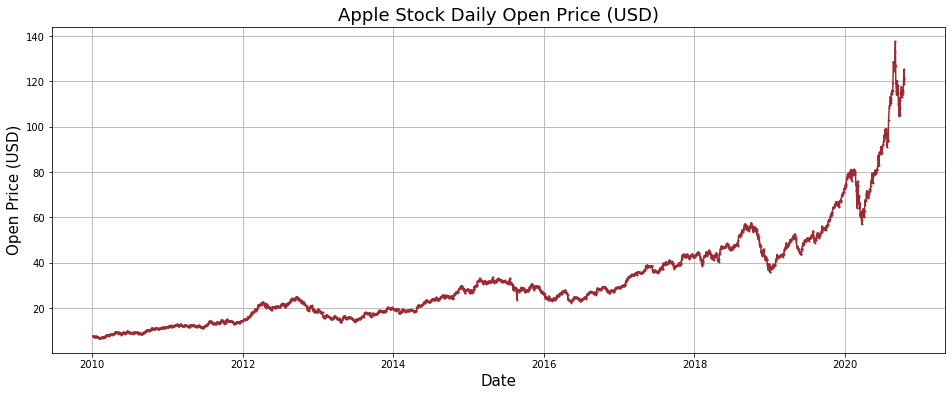

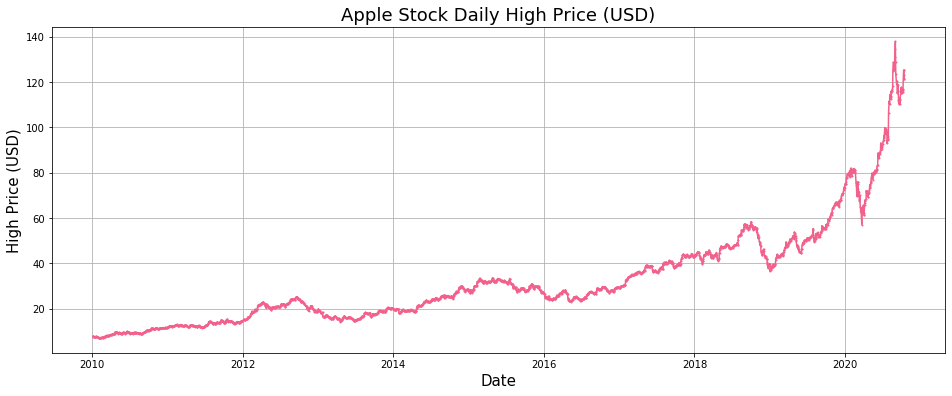

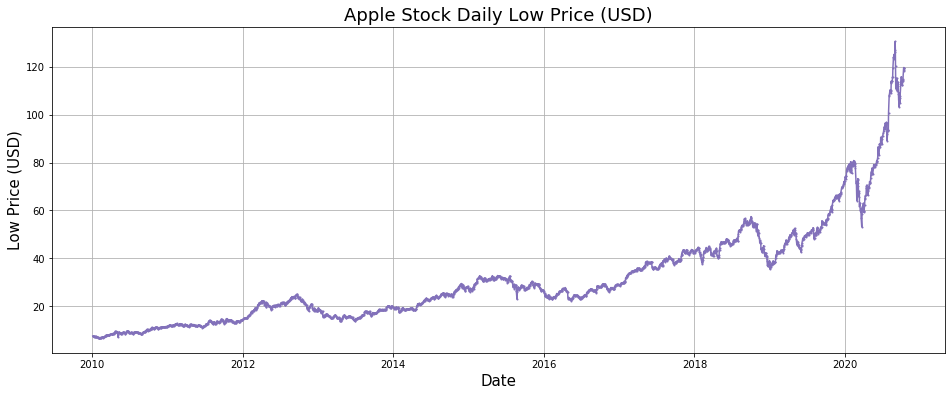

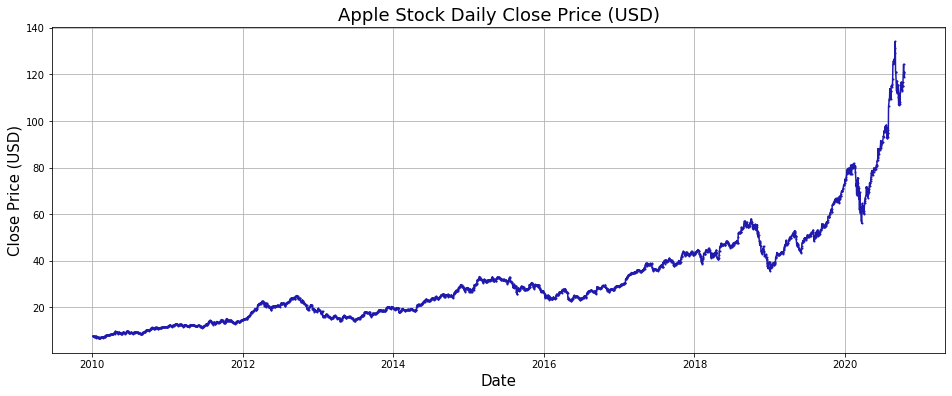

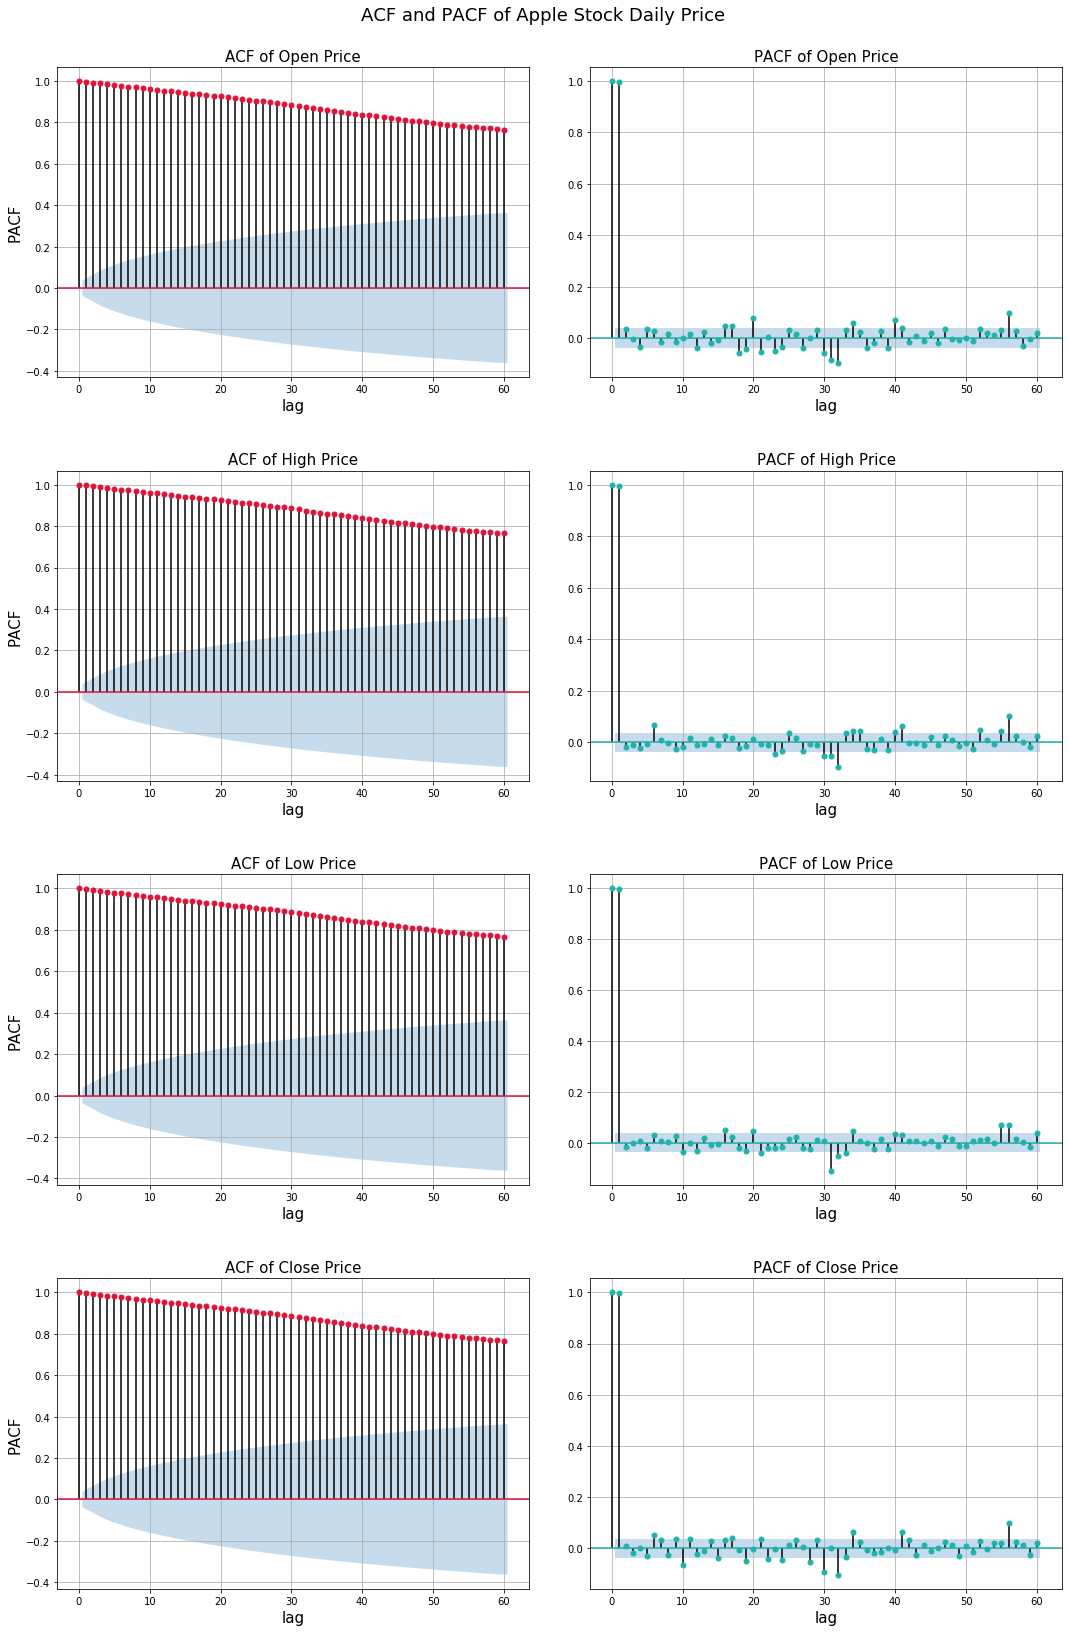

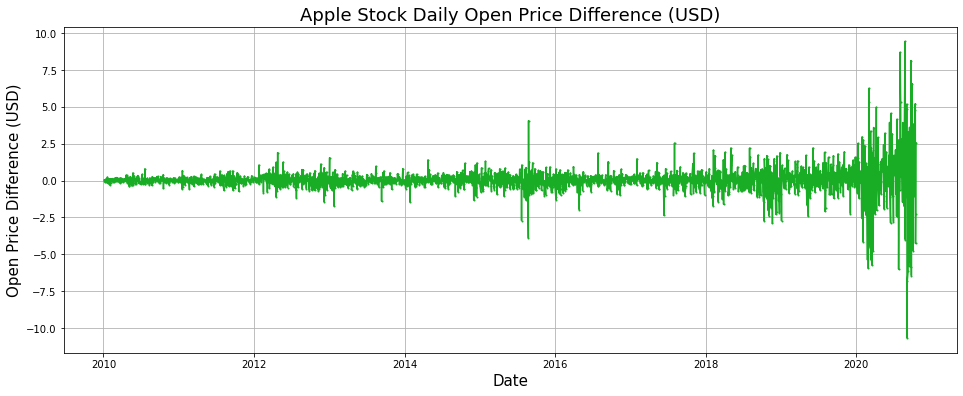

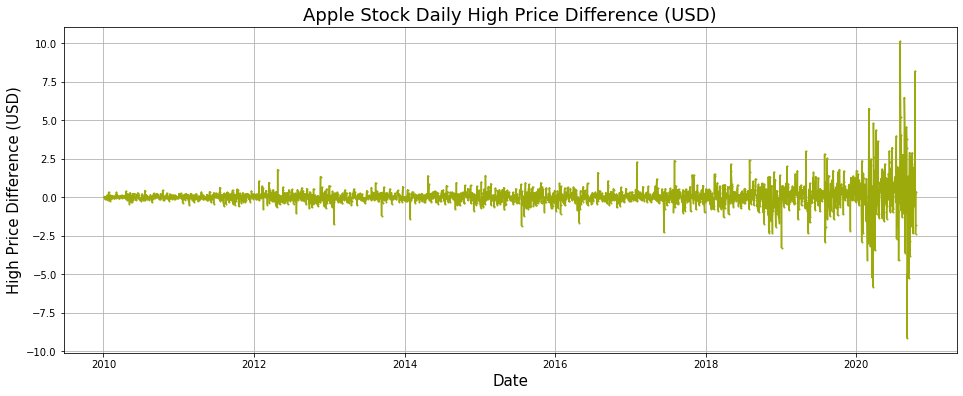

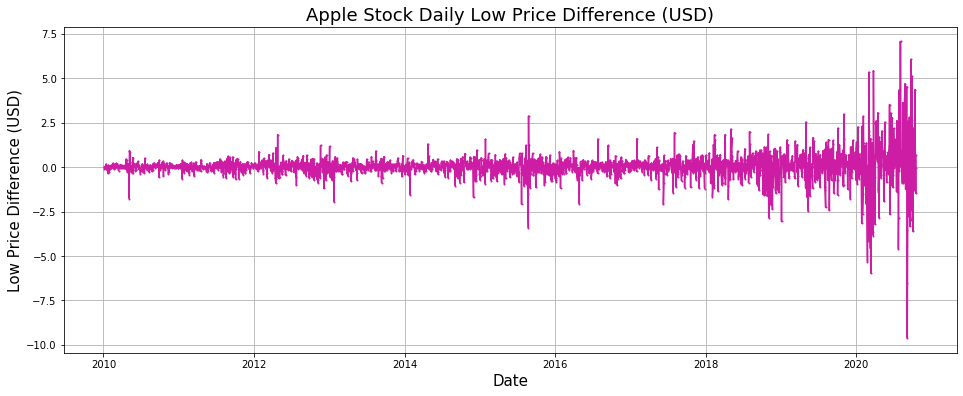

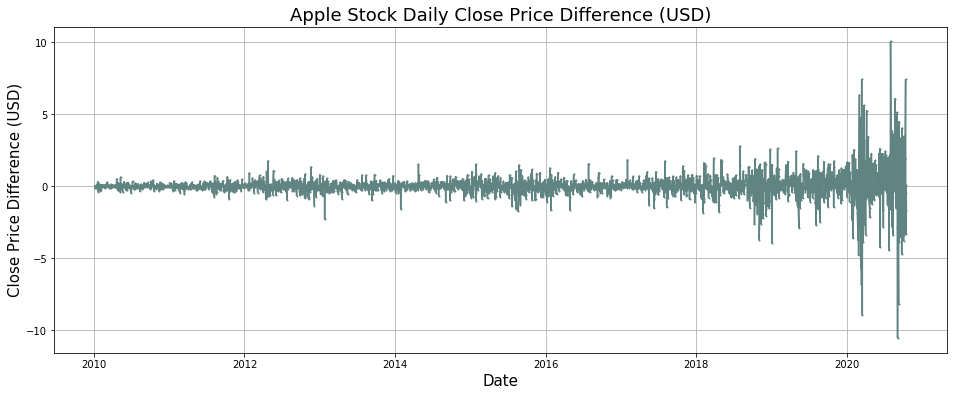

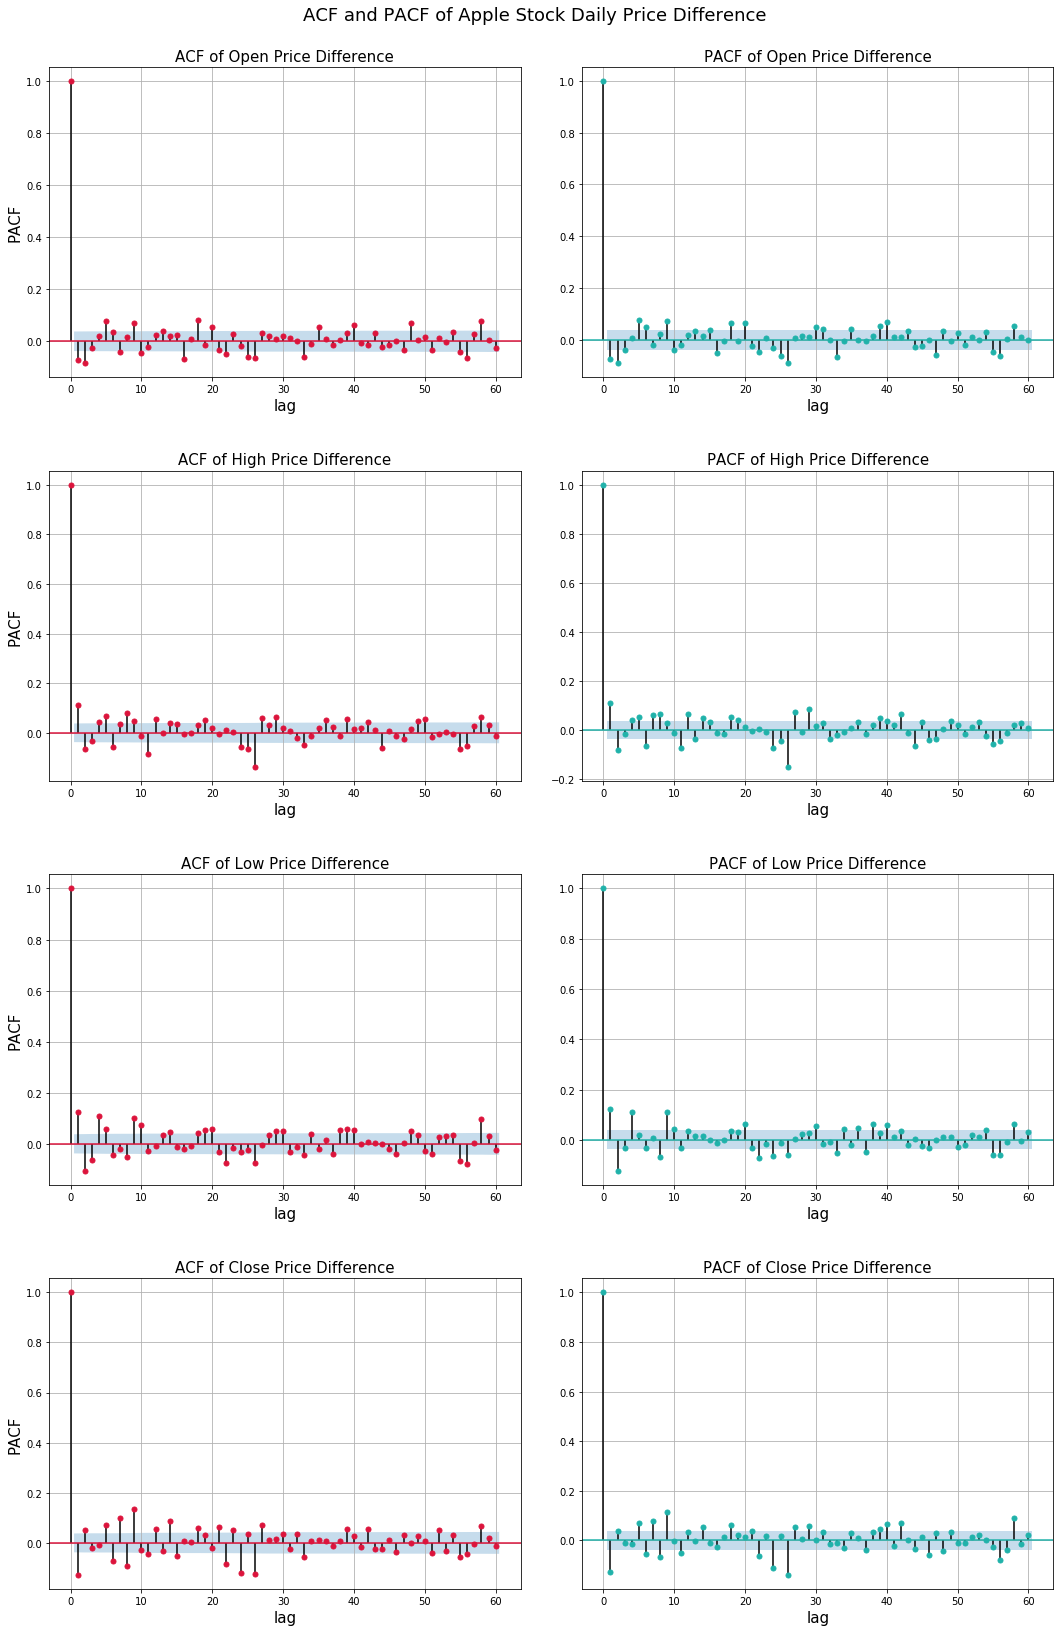

In [134]:
for i in range(len(security_list)):
    print("\n************************ Processing", security_list[i], "************************")

    df = read_data(file_list[i])
    df_diff = df.diff().dropna()
    describe_and_peek(df, security_list[i])

    display_charts(df, security_list[i], "Price")
    plot_acf_pacf(df, security_list[i], "Price")

    display_charts(df_diff, security_list[i], "Price Difference")
    plot_acf_pacf(df_diff, security_list[i], "Price Difference")

# Modelling

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

verbose = False

# Common Functions for all the Problems

In [ ]:
def perform_scaling(df):    
     # Create a new dataframe for the scaled values
    df_scaled = df.copy()

    # Variable to save the MinMaxScaler scalar object used for open price transformation
    scalar_open = None

    # Scale the data
    for column in df_scaled.columns:
        # Create a new MinMaxScaler scalar object 
        scaler = MinMaxScaler(feature_range = (0, 1))

        # Apply the transformaion on current column
        df_scaled[column] = scaler.fit_transform(df_scaled[[column]])

        # Save the MinMaxScaler object used for open price for reverse transformation
        if column == 'Open':
            scalar_open = scaler
            
    return df_scaled, scalar_open

In [2]:
# Given history displays loss and RMSE curves
def plot_loss_and_rmse(history):
    # Extract loss and accuracy
    loss = history.history['loss']
    rmse = history.history['rmse']

    val_loss = history.history['val_loss']
    val_rmse = history.history['val_rmse']

    epochs = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
    
    ax[0].plot(epochs, loss, '-o', label='Training Loss')
    ax[0].plot(epochs, val_loss, '-o', color='r', label='Validation Loss')
    ax[0].grid(color='black', which='major', linestyle='dashed')
    ax[0].set_title('Training and Validation Loss', fontsize=18)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=12)

    ax[1].plot(epochs, rmse, '-o', label='Training RMSE')
    ax[1].plot(epochs, val_rmse, '-o', color='r', label='Validation RMSE')
    ax[1].grid(color='black', which='major', linestyle='dashed')
    ax[1].set_title('Training and Validation RMSE', fontsize=18)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('RMSE', fontsize=15)
    ax[1].legend(fontsize=12)

    plt.show();

In [3]:
def build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, epochs, look_ahead):
    
    # Create the model
    model = Sequential()

    # Add LSTM and Dropout Layers
    model.add(CuDNNLSTM(units=150, return_sequences=True,
                        input_shape=(train_features_set.shape[1], train_features_set.shape[2])))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150))
    model.add(Dropout(0.2))

    # Add dense layers
    model.add(Dense(units = look_ahead))

    # Print the model summary
    print("\nSummary of the model:\n")
    model.summary()

    # Compile the Model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

    print("\nTraining the model...\n")

    # Train the model
    history = model.fit(train_features_set,
                        train_labels,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(val_features_set, val_labels),
                        verbose=verbose)

    print("Training completed!\n")
    
    return model, history

In [ ]:
for i in range(len(security_list)):
    print("\n************************ Processing", security_list[i], "************************")

    df = read_data(file_list[i])   
    
    # Scale Data
    df_scaled, scalar_open = perform_scaling(df)    
    
    # Compute Training, Validation and Test Set Sizes
    training_size = len(df_scaled.loc['2010-01-04':'2020-05-29']) - window_size
    validation_size = len(df_scaled.loc['2020-06-01':'2020-09-18'])
    test_size = len(df_scaled.loc['2020-09-19':'2020-10-16'])

    # Print Training, Validation and Test Set Sizes
    print("Training Size:", training_size)
    print("Validation Size:", validation_size)
    print("Test Size:", test_size)

# Univariate Model - Single Day Prediction

In [11]:
# Number of days to predict
look_ahead = 1

# Convert dataframe to numpy array
apple_open = df_apple_scaled[['Open']].values

# Extract datetime for the test data from the dataframe index
dates_1 = df_apple_scaled.tail(test_size).index.format()

# Create Training, Validation and Test Feature Sets and Labels
train_features_set = []
train_labels = []

val_features_set = []
val_labels = []

test_features_set = []
test_labels = []

for i in range(window_size, len(apple_open)):
    if i < window_size + training_size:
        train_features_set.append(apple_open[i-window_size:i, 0])
        train_labels.append(apple_open[i, 0])
    elif i < (window_size + training_size + validation_size):
        val_features_set.append(apple_open[i-window_size:i, 0])
        val_labels.append(apple_open[i, 0])
    else:
        test_features_set.append(apple_open[i-window_size:i, 0])
        test_labels.append(apple_open[i, 0])
        
# Convert features set and label lists to numpy arrays
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
val_features_set, val_labels = np.array(val_features_set), np.array(val_labels)
test_features_set, test_labels = np.array(test_features_set), np.array(test_labels)

# Reshape Training, Validation and Test Feature Sets to fit LSTM input shape
train_features_set = np.reshape(train_features_set, (train_features_set.shape[0], train_features_set.shape[1], 1))
val_features_set = np.reshape(val_features_set, (val_features_set.shape[0], val_features_set.shape[1], 1))
test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))

Training Feature Set and Label Sizes: 2559 2559
Validation Feature Set and Label Sizes: 78 78
Test Feature Set and Label Sizes: 20 20


In [ ]:
# Create and train a new sequential model as per the specifications
model_1, history_1 = build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, 100, look_ahead)

# Save the model
model_1.save('apple_open_problem_1.h5', save_format='tf')

# Display loss and RMSE curves
plot_loss_and_rmse(history_1)

In [15]:
# Use the model to predict for the test data
predictions_1 = model_1.predict(test_features_set)

# Convert the predicted values to origianl scale
predictions_1 = scalar_open.inverse_transform(predictions_1)

# Convert actual values to origianl scale
actual_1 = scalar_open.inverse_transform(test_labels.reshape(-1, 1))

# Plot actual and predicted open prices for the test data
plt.figure(figsize=(16, 8))
plt.plot(dates_1, actual_1, "-o", color='b', label='Actual')
plt.plot(dates_1, predictions_1, "-o", color='r', label='Predicted')
plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Univariate Model", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Open Price (USD)", fontsize=15)
plt.xticks(dates_1[::2])
plt.legend(fontsize=12)
plt.grid(True);

print("MSE value for the Univariate Model: {:.2f}".format(mean_squared_error(actual_1, predictions_1)))

# Univariate Model - Multi Day Prediction

In [ ]:
# Number of days to predict
look_ahead = 5

# Convert dataframe to numpy array
apple_open = df_apple_scaled[['Open']].values

# Extract datetime for the test data from the dataframe index
dates_2 = df_apple_scaled.tail(test_size)[:test_size-look_ahead+1].index.format()

# Create Training, Validation and Test Feature Sets and Labels
train_features_set = []
train_labels = []

val_features_set = []
val_labels = []

test_features_set = []
test_labels = []

for i in range(window_size, len(apple_open) - look_ahead + 1):    
    if i < window_size + training_size:
        train_features_set.append(apple_open[i-window_size:i, 0])
        train_labels.append(apple_open[i:i+look_ahead, 0])
    elif i < (window_size + training_size + validation_size):
        val_features_set.append(apple_open[i-window_size:i, 0])
        val_labels.append(apple_open[i:i+look_ahead, 0])
    else:
        test_features_set.append(apple_open[i-window_size:i, 0])
        test_labels.append(apple_open[i:i+look_ahead, 0])

# Convert features set and label lists to numpy arrays
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
val_features_set, val_labels = np.array(val_features_set), np.array(val_labels)
test_features_set, test_labels = np.array(test_features_set), np.array(test_labels)

# Reshape data to fit LSTM input shape
train_features_set = np.reshape(train_features_set, (train_features_set.shape[0], train_features_set.shape[1], 1))
val_features_set = np.reshape(val_features_set, (val_features_set.shape[0], val_features_set.shape[1], 1))
test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))

In [ ]:
# Create and train a new sequential model as per the specifications
model_2, history_2 = build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, 100, look_ahead)

# Save the model
model_2.save('apple_open_problem_2.h5', save_format='tf')

# Display loss and RMSE curves
plot_loss_and_rmse(history_2)

In [22]:
# Use the model to predict for the test data
predictions_2 = model_2.predict(test_features_set)

# Convert the predicted values to origianl scale
predictions_2 = scalar_open.inverse_transform(predictions_2)

# Convert actual values to origianl scale
actual_2 = scalar_open.inverse_transform(test_labels)

# Plot actual and predicted open prices for the test data for each look ahead value
for i in range(look_ahead):
    plt.figure(figsize=(16, 8))
    plt.plot(dates_2, actual_2[:, i], "-o", color=np.random.rand(3,), label='Actual')
    plt.plot(dates_2, predictions_2[:, i], "-o", color=np.random.rand(3,), label='Predicted')
    plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Univariate Model - Look ahead - " + str(i+1), fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Open Price (USD)", fontsize=15)
    plt.xticks(dates_2[::2])
    plt.legend(fontsize=12)
    plt.grid(True);
    
print("MSE value for the Univariate Look ahead Model: {:.2f}".format(mean_squared_error(actual_2, predictions_2)))

# Multivariate Model

In [25]:
# Number of days to predict
look_ahead = 1

# Convert dataframe to numpy array

apple_all = df_apple_scaled.values
apple_open = df_apple_scaled[['Open']].values

# Extract datetime for the test data from the dataframe index
dates_3 = df_apple_scaled.tail(test_size).index.format()

# Create Training, Validation and Test Feature Sets and Labels
train_features_set = []
train_labels = []

val_features_set = []
val_labels = []

test_features_set = []
test_labels = []

for i in range(window_size, len(apple_open)):
    if i < window_size + training_size:
        train_features_set.append(apple_all[i-window_size:i, :])
        train_labels.append(apple_open[i, 0])
    elif i < (window_size + training_size + validation_size):
        val_features_set.append(apple_all[i-window_size:i, :])
        val_labels.append(apple_open[i, 0])
    else:
        test_features_set.append(apple_all[i-window_size:i, :])
        test_labels.append(apple_open[i, 0])

# Convert features set and label lists to numpy arrays
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
val_features_set, val_labels = np.array(val_features_set), np.array(val_labels)
test_features_set, test_labels = np.array(test_features_set), np.array(test_labels)

Training Feature Set and Label Sizes: 2559 2559
Validation Feature Set and Label Sizes: 78 78
Test Feature Set and Label Sizes: 20 20


In [ ]:
# Create and train a new sequential model as per the specifications
model_3, history_3 = build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, 100, look_ahead)

# Save the model
model_3.save('apple_open_problem_3.h5', save_format='tf')

# Display loss and rmse curves
plot_loss_and_rmse(history_3)

In [29]:
# Use the model to predict for the test data
predictions_3 = model_3.predict(test_features_set)

# Convert the predicted values to origianl scale
predictions_3 = scalar_open.inverse_transform(predictions_3)

# Convert actual values to origianl scale
actual_3 = scalar_open.inverse_transform(test_labels.reshape(-1, 1))

# Plot actual and predicted open prices for the test data
plt.figure(figsize=(16, 8))
plt.plot(dates_3, actual_3, "-o", color='b', label='Actual')
plt.plot(dates_3, predictions_3, "-o", color='r', label='Predicted')
plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Multivariate Model", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Open Price (USD)", fontsize=15)
plt.xticks(dates_3[::2])
plt.legend(fontsize=12)
plt.grid(True);

# Plot actual and predicted open prices for the test data
plt.figure(figsize=(16, 8))
plt.plot(dates_3, actual_3, "-o", color='b', label='Actual')
plt.plot(dates_3, predictions_3, "-o", color='r', label='Predicted')
plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Multivariate Model", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Open Price (USD)", fontsize=15)
plt.xticks(dates_3[::2])
plt.legend(fontsize=12)
plt.grid(True);

print("MSE value for the Multivariate Model: {:.2f}".format(mean_squared_error(actual_3, predictions_3)))